In [1]:
# Numerics
import qutip as qt
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.gridspec import GridSpec

# Tracking info of simulations
import tqdm
import time
import warnings

#Saving data
import pandas as pd
import json
import os

#peak analysis
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

# Suppress DeprecationWarning
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
#Pauli matrices
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()
#Identity
I = qt.qeye(2)
#sigma+-
sm = qt.destroy(2)
sp = qt.create(2)

ket0 = qt.basis(2, 0)
ket1 = qt.basis(2, 1)

#two-qubit basis
ket00 = qt.tensor([ket0,ket0])
ket01 = qt.tensor([ket0,ket1])
ket10 = qt.tensor([ket1,ket0])
ket11 = qt.tensor([ket1,ket1])

#Bell basis
psi_p = 1/np.sqrt(2)*(ket00 + ket11)
psi_m = 1/np.sqrt(2)*(ket00 - ket11)
phi_p = 1/np.sqrt(2)*(ket01 + ket10)
phi_m = 1/np.sqrt(2)*(ket01 - ket10)

In [3]:
#basis in DW
#1 qubit
ket0_dw = qt.tensor([ket0,ket0])
ket1_dw = qt.tensor([ket1,ket0])

#2 qubit
# ket00_dw = qt.tensor([ket0,ket0,ket0])
# ket01_dw = qt.tensor([ket1,ket1,ket0])
# ket10_dw = qt.tensor([ket1,ket0,ket0])
# ket11_dw = qt.tensor([ket0,ket1,ket0])

ket00_dw = qt.tensor([ket0,ket0])
ket01_dw = qt.tensor([ket1,ket1])
ket10_dw = qt.tensor([ket1,ket0])
ket11_dw = qt.tensor([ket0,ket1])

#Bell
psi_p_dw = 1/np.sqrt(2)*(ket00_dw + ket11_dw)
psi_m_dw = 1/np.sqrt(2)*(ket00_dw - ket11_dw)
phi_p_dw = 1/np.sqrt(2)*(ket01_dw + ket10_dw)
phi_m_dw = 1/np.sqrt(2)*(ket01_dw - ket10_dw)

In [4]:
#3 qubit basis in DW

ket000_dw = qt.tensor([ket0,ket0,ket0])
ket001_dw = qt.tensor([ket1,ket1,ket1])
ket010_dw = qt.tensor([ket1,ket1,ket0])
ket011_dw = qt.tensor([ket0,ket0,ket1])
ket100_dw = qt.tensor([ket1,ket0,ket0])
ket101_dw = qt.tensor([ket0,ket1,ket1])
ket110_dw = qt.tensor([ket0,ket1,ket0])
ket111_dw = qt.tensor([ket1,ket0,ket1])

In [5]:
def create_input_register(a, b, c, d):
    return a*ket00_dw + b*ket01_dw + c*ket10_dw + d*ket11_dw

In [6]:
def initialize_1_qubit_system(size, alpha, beta): 
    #Initialize first spin in a superposition of |0> and |1>
    #Initialize the rest of the spins in |0>
    psi0_1 = alpha*qt.basis(2,1) + beta*qt.basis(2,0)
    state_list = [psi0_1] + [qt.basis(2, 0)] * (size - 1)

    #Total state is product state of spins
    initial_state = qt.tensor(state_list) 

    print("Initializing system of size", size, "\n",
          "First spin in state {:.4f} |0> + {:.4f} |1>\n".format(alpha, beta))
    
    return initial_state


def generate_target_1(size, alpha, beta): 
    #Initialize first spin in a superposition of |0> and |1>
    #Initialize the rest of the spins in |0>
    psif_N = alpha*qt.basis(2,1) + beta*qt.basis(2,0)
    state_list = [qt.basis(2, 0)] * (size - 1) + [psif_N] 

    #Total state is product state of spins
    final_state = qt.tensor(state_list) 
    
    return final_state


def initialize_general_system(size, alice_register): # alice_register is already in domain wall encoding
    #initialize chain
    #check that initial state is a valid one
    if abs(1 - abs(alice_register.dag()*alice_register)) > 0.0001:
        print("Initial state is not valid")
        return
    
    alice_reg_len = len(alice_register.dims[0])
    #check that chain is long enough to do transport
    if alice_reg_len*2 >= size:
        print("Chain too short to transport initial state")
        return
     
    chain = [qt.basis(2, 0)]*(size - alice_reg_len)
    chain_state = qt.tensor(chain)

    #Total state is product state of spins
    initial_state = qt.tensor(alice_register, chain_state) 
    
    return initial_state


def generate_target(size, bob_register): 
    #check that final state is a valid one
    if abs(1 - abs(bob_register.dag()*bob_register)) > 0.0001:
        print("Initial state is not valid")
        return
    
    bob_reg_len = len(bob_register.dims[0])
    #check that chain is long enough to do transport
    if bob_reg_len*2 >= size:
        print("Chain too short to transport initial state")
        return
     
    chain = [qt.basis(2, 0)]*(size - bob_reg_len)
    chain_state = qt.tensor(chain)

    #Total state is product state of spins
    final_state = qt.tensor(chain_state, bob_register) 
    
    return final_state


def normalize_state(state):
    norm = np.sqrt(state.dag()*state)
    return state/norm
    

In [7]:
def crate_domain_wall_state(state_dictionary):
    # example: |psi> = ["001":0.4,"101":0.2,"111":0.6,"110":0.35]
    state = 0
    for i, term in enumerate(state_dictionary.keys()):
        dw_spins = []
        #first bit is always a down wire qubit
        last_spin = "0"
        #reverse order and loop over bits
        for bit in term[::-1]:
            #put 0 or 1 to create (or not) domain wall
            if bit == "1":
                if last_spin == "0":
                    dw_spins.append(ket1)
                    last_spin = "1"
                elif last_spin == "1":
                    dw_spins.append(ket0)
                    last_spin = "0"
            elif bit == "0":
                if last_spin == "0":
                    dw_spins.append(ket0)
                    last_spin = "0"
                elif last_spin == "1":
                    dw_spins.append(ket1)
                    last_spin = "1"
        #reverse order of list again and make tensor product
        dw_term = qt.tensor(dw_spins[::-1])
        #add to full state with corresponding weight
        state += state_dictionary[term]*dw_term
    # normalize
    norm = np.sqrt(state.dag()*state)
    return state/norm


def create_domain_wall_target(state_dictionary):
    # example: |psi> = ["001":0.4,"101":0.2,"111":0.6,"110":0.35]
    state = 0
    for i, term in enumerate(state_dictionary.keys()):
        dw_spins = []
        #first bit is always a down wire qubit
        last_spin = "0"
        #loop over bits (w/o reversing order this time)
        for bit in term:
            #put 0 or 1 to create (or not) domain wall
            if bit == "1":
                if last_spin == "0":
                    dw_spins.append(ket1)
                    last_spin = "1"
                elif last_spin == "1":
                    dw_spins.append(ket0)
                    last_spin = "0"
            elif bit == "0":
                if last_spin == "0":
                    dw_spins.append(ket0)
                    last_spin = "0"
                elif last_spin == "1":
                    dw_spins.append(ket1)
                    last_spin = "1"
        #reverse order of list and make tensor product
        dw_term = qt.tensor(dw_spins[::-1])
        #add to full state with corresponding weight
        state += state_dictionary[term]*dw_term
    # normalize
    norm = np.sqrt(state.dag()*state)
    return state/norm
        

In [8]:
#Define the coupling values
def J_definition(size, factor):
    strengths = np.zeros(size)
    for i in range(0,size):
        strengths[i] = 0.5*factor*np.sqrt((i+1)*(size-i))
    return strengths

#couplings in domain wall
def tn_definition(data_j):
    size = len(data_j)
    out = np.zeros(size)
    for i in range(size):
        out[i] = -data_j[i]
    return out

In [ ]:
def Initialize_Hamiltonian(n_spins):    
# Setup operators for individual qubits
    sx_list, sy_list, sz_list = [], [], []
    #for each value of i it puts the paulis in different positions of the list, then does IxIxI...sigma_ixIxI...xI
    for i in range(n_spins):
        #list of 2x2 identity matrices
        op_list = [qt.qeye(2)] * n_spins
        #replace i-th element with sigma_x
        op_list[i] = sx
        #create matrices of 2^Nx2^N
        sx_list.append(qt.tensor(op_list))
        #do the same for sigma_y and sigma_z
        op_list[i] = sy
        sy_list.append(qt.tensor(op_list))
        op_list[i] = sz
        sz_list.append(qt.tensor(op_list))

    return sx_list, sy_list, sz_list

In [10]:
def  Hamiltonian_forward(n_spins, J_global, t_couplings, sx_list, sy_list, sz_list):
    Ham = 0
    #Transverse field but not in first spin
    for i in range(1, n_spins):
        Ham += -t_couplings[i-1] * sx_list[i]
        # print("Transverse field on spin", i, "=", t_couplings[i-1])

    #Virtual qubit down at end of chain
    Ham+= +J_global*sz_list[n_spins-1]

    #Interaction terms with the rest of the spins
    for i in range(0, n_spins-1):
        Ham += J_global* sz_list[i]*sz_list[i+1]

    return Ham

def  Hamiltonian_backward(n_spins, reg_size, J_global, t_couplings, sx_list, sy_list, sz_list):
    Ham = 0
    #Transverse field but not in Bob's register
    for i in range(0, n_spins - reg_size):
        Ham += -t_couplings[i] * sx_list[i]
        # print("Transverse field on spin", i, "=", t_couplings[i])

    #Virtual qubit down at start of chain
    Ham += +J_global*sz_list[0]
    #Ham+= +J_global*sz_list[n_spins-1]

    #Interaction terms with the rest of the spins
    for i in range(0, n_spins-1):
        Ham += J_global* sz_list[i]*sz_list[i+1]

    return Ham

In [11]:
def time_evolution(Ham, sigma_z_list,  initial_state, initial_time, final_time, timesteps): 
    times = np.linspace(initial_time, final_time, timesteps)
    #apply hamiltonian to initial state and don't track any observables
    options = {
    'method': 'adams', 
    'progress_bar': 'tqdm'
}
    simulation_results = qt.sesolve(Ham, initial_state, times, options = options)

    print("Simulated evolution from time", initial_time, "to", final_time, "in", timesteps, "steps \n")

    return simulation_results

In [12]:
def calculate_fidelities(n_spins, state_evolution, initial_state = None, mode = "maximum"): 
    #Calculate fidelities and find maximum
    if initial_state is None:
        rho_0 = (qt.basis(2,1)*qt.basis(2,1).dag())
    else:
        rho_0 = (initial_state * initial_state.dag()).ptrace(0)
    fidelities = np.zeros((len(state_evolution), n_spins))

    for index, state in enumerate(state_evolution):
        #update if new minimum is found
        for site in range(n_spins):
            rho_n = state.ptrace(site)
            fidelities[index, site] = (qt.fidelity(rho_0, rho_n))
    if mode == "maximum":
        max_fid = [np.max(fidelities[:,i]) for i in range(n_spins)]
        max_fid_index = [np.argmax(fidelities[:,i]) for i in range(n_spins)]
    elif mode == "minimum":
        max_fid = [np.min(fidelities[:,i]) for i in range(n_spins)]
        max_fid_index = [np.argmin(fidelities[:,i]) for i in range(n_spins)]


    return fidelities, max_fid, max_fid_index



def calculate_full_fidelity(n_spins, state_evolution, target_state = None): 
    #Calculate fidelities and find maximum
    if target_state is None:
        state_list = [qt.basis(2, 0)] * (size - 1) + [psi0_1] 
        target_state = qt.tensor(state_list)
    
    #target_state = target_state * target_state.dag()

    fidelity = np.zeros(len(state_evolution.times))

    for index, state in enumerate(state_evolution.states):
         fidelity[index] = (qt.fidelity(target_state, state))

    return fidelity

def calculate_bob_fidelity(n_spins, register_length, state_evolution, target_state):

    #determine the qubits we will trace out
    qubit_register = []
    for i in range(register_length):
        qubit_register.append(n_spins - i -1)
    target_register = target_state.ptrace(qubit_register)

    fidelity = np.zeros(len(state_evolution.times))
    for index, state in enumerate(state_evolution.states):
         traced_state = state.ptrace(qubit_register)
         fidelity[index] = (qt.fidelity(target_register, traced_state))

    return fidelity


def calculate_diagonal_fidelity(n_spins, state_evolution, target_state = None):
    
    fidelity = np.zeros(len(state_evolution.times))
    target_diag = np.abs(target_state.full())**2

    for index, state in enumerate(state_evolution.states):
         state_diag = np.abs(state.full())**2
         fidelity[index] = np.sum(np.sqrt(target_diag * state_diag))**2

    return fidelity






In [13]:
def calculate_z_expectation_values(n_spins, initial_state, state_evolution, sigma_z_list):    
    #Find minimum difference between expected Z val of last spin and initial Z of first spin
    #calculate expectation value of sz for each spin
    magn_t = np.array([[qt.expect(op, state) for op in sigma_z_list] for state in state_evolution.states])
    #find maximums
    max_magn_i = [np.max(magn_t[:,i]) for i in range(n_spins)]
    max_magn_i_index = [np.argmax(magn_t[:,i]) for i in range(n_spins)]

    return magn_t, max_magn_i, max_magn_i_index

In [55]:
def WRM_algorithm(N, lmd, J, alice_register, target_register, ti, tf, Nstep):

    #Hamiltonian parameters
    Jn = J_definition(N-1, lmd)
    tn = tn_definition(Jn)
    register_length = len(alice_register.dims[0])

    #state that we want to transfer and target final state
    initial_state = initialize_general_system(N, alice_register)  #generate whole chain
    final_state = generate_target(N, target_register)

    sxl, syl, szl = Initialize_Hamiltonian(N)

    # CALIBRATION
    H = Hamiltonian_forward(N, J, tn, sxl, syl, szl) 
    # evolve
    results_c = time_evolution(H, szl, initial_state, ti, tf, Nstep)
    # calculate fidelity and magnetization
    full_fidelity_c = calculate_full_fidelity(N, results_c, final_state)
    magnetizations_c, min_magn_c, min_magn_index_c = calculate_z_expectation_values(N, initial_state, results_c, szl)
    # Determine period of max fidelity
    step_of_min_magnetization = max(int(np.argmin(magnetizations_c[:,-1])),10) # max in case fidelity starts at 1
    # step_of_min_magnetization = max(int(np.argmax(magnetizations_c[440:,-3])),0) + 440 # max in case fidelity starts at 1
    step_of_min_magnetization = 464
    period = (tf - ti)*step_of_min_magnetization/Nstep
    print(step_of_min_magnetization)
    print(period)

    # BACK AND FORTH ALGORITHM
    H = Hamiltonian_forward(N, J, tn, sxl, syl, szl)
    results_f = time_evolution(H, szl, initial_state, ti, period, int(step_of_min_magnetization))
    full_fidelity_f = calculate_full_fidelity(N, results_f, final_state)
    magnetizations_f, min_magn_f, min_magn_index_f = calculate_z_expectation_values(N, initial_state, results_f, szl)
    traced_fidelity_f = calculate_bob_fidelity(N, register_length, results_f, final_state)
    diagonal_fidelity_f = calculate_diagonal_fidelity(N, results_f, final_state)

    #Redefine couplings
    Jn = J_definition(N-register_length, lmd)
    tn = tn_definition(Jn)

    H = Hamiltonian_backward(N, register_length, J, tn, sxl, syl, szl)
    results_b = time_evolution(H, szl, results_f.states[-1] , ti, period*1.12, int(step_of_min_magnetization*1.12))
    full_fidelity_b = calculate_full_fidelity(N, results_b, final_state)
    magnetizations_b, min_magn_b, min_magn_index_b = calculate_z_expectation_values(N, initial_state, results_b, szl)
    traced_fidelity_b = calculate_bob_fidelity(N, register_length, results_b, final_state)
    diagonal_fidelity_b = calculate_diagonal_fidelity(N, results_b, final_state)

    return full_fidelity_c , full_fidelity_f, full_fidelity_b, \
           step_of_min_magnetization, period, \
           magnetizations_c, magnetizations_f, magnetizations_b, \
           traced_fidelity_f, traced_fidelity_b, \
           diagonal_fidelity_f, diagonal_fidelity_b




In [56]:
N = 13
# lmd = np.linspace(0.1, 1, 10)
J = 0.5
#J = 0.3
# J = range(1,21)
lmd = 0.02272
#lmd = 0.0
#Evolution parameters
initial_time = 0
final_time = 150
step_number = 500

# 1 QUBIT
# state_dictionary = {"1":3,"0":1}
# state_dictionary = {"1":1, "0":1}
# state_dictionary = {"1":1}

# 2 QUBIT
# state_dictionary = {"11":1}
# state_dictionary = {"11":1, "00":1}
# state_dictionary = {"11":-1, "00":1, "01":1, "10":1} #C2  
 
# 3 QUBIT
# state_dictionary = {"111":1, "000":1}                    # GHZ
# state_dictionary = {"001":1, "010":1, "100":1}           # W
state_dictionary = {"000":1, "011":1, "101":1, "110":1}  # CLUSTER

# state_dictionary = {"001":1}
# state_dictionary = {"001":0.4,"101":0.2,"111":0.6,"110":0.35}

input_register = crate_domain_wall_state(state_dictionary)

#input_register = ket110_dw
target_state = create_domain_wall_target(state_dictionary)

# input_register = psi_p_dw

# target_state = psi_p_dw


f_c , f_f, f_b, period_step, period, m_c, m_f, m_b, tfc, tfb, dff, dfb = WRM_algorithm(N, lmd, J, input_register, target_state, initial_time, final_time, step_number)

full_fidelity = np.concatenate((f_f, f_b), axis=0)
magnetizations = np.concatenate((m_f, m_b), axis=0)

100%|██████████| 499/499 [00:03<00:00, 142.62it/s]


Simulated evolution from time 0 to 150 in 500 steps 

464
139.2


100%|██████████| 463/463 [00:02<00:00, 154.57it/s]


Simulated evolution from time 0 to 139.2 in 464 steps 



100%|██████████| 518/518 [00:03<00:00, 170.77it/s]


Simulated evolution from time 0 to 155.904 in 519 steps 



In [94]:
full_fidelity_1 = full_fidelity

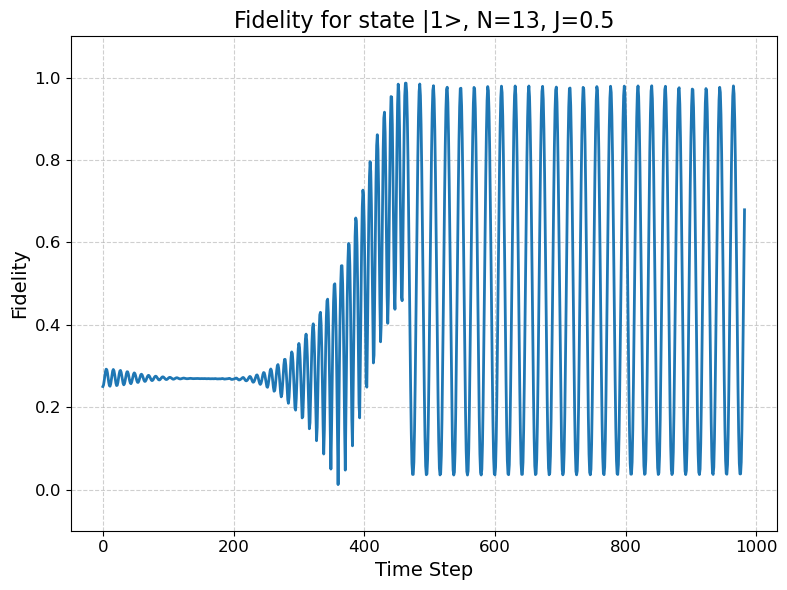

0.9863870195352404
463


In [57]:
total_full_fidelity = np.concatenate((f_f, f_b), axis=0)
#total_full_fidelity = np.concatenate((tfc, tfb), axis=0) 
#total_full_fidelity = np.concatenate((dff, dfb), axis=0)
plt.figure(figsize=(8, 6))
# Plot each curve
num_steps = len(total_full_fidelity)
plt.plot(range(num_steps), total_full_fidelity, label=f'Fidelity', linestyle='-', linewidth=2)

# Add labels, title, legend, and grid
plt.ylim(-0.1, 1.1)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)
# plt.title('<Z> for N=7, J=-5, α = 1', fontsize=16)
# plt.title('Fidelity for N=7, J=5, α = 0.8', fontsize=16)
plt.title(f'Fidelity for state |1>, N={N}, J={J}', fontsize=16)
# plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tick_params(axis='both', labelsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

print(max(total_full_fidelity))
print(np.argmax(total_full_fidelity))

In [18]:
fidelity_11 = total_full_fidelity

In [34]:
fidelity_bell = total_full_fidelity

In [31]:
fidelity_cluster_2 = total_full_fidelity

In [38]:
fidelity_ghz = total_full_fidelity

In [42]:
fidelity_w = total_full_fidelity

In [58]:
fidelity_cluster_3 = total_full_fidelity

In [68]:
import json
# save into file
def save_fidelity(fid_list, filename):
    np.save(filename, fid_list)
    return

# Load from file
def read_fidelity(filename):
    loaded_list = np.load(filename)
    return loaded_list




In [71]:
save_fidelity(fidelity_11, 'fidelities/fidelity_11.npy')
save_fidelity(fidelity_bell, 'fidelities/fidelity_bell.npy')
save_fidelity(fidelity_cluster_2, 'fidelities/fidelity_cluster_2.npy')
save_fidelity(fidelity_ghz, 'fidelities/fidelity_ghz.npy')
save_fidelity(fidelity_w, 'fidelities/fidelity_w.npy')
save_fidelity(fidelity_cluster_3, 'fidelities/fidelity_cluster_3.npy')

In [85]:
fidelity_11_recovered = read_fidelity('fidelities/fidelity_11.npy')
fidelity_bell_recovered = read_fidelity('fidelities/fidelity_bell.npy')
fidelity_cluster_2_recovered = read_fidelity('fidelities/fidelity_cluster_2.npy')
fidelity_ghz_recovered = read_fidelity('fidelities/fidelity_ghz.npy')
fidelity_w_recovered = read_fidelity('fidelities/fidelity_w.npy')
fidelity_cluster_3_recovered = read_fidelity('fidelities/fidelity_cluster_3.npy')

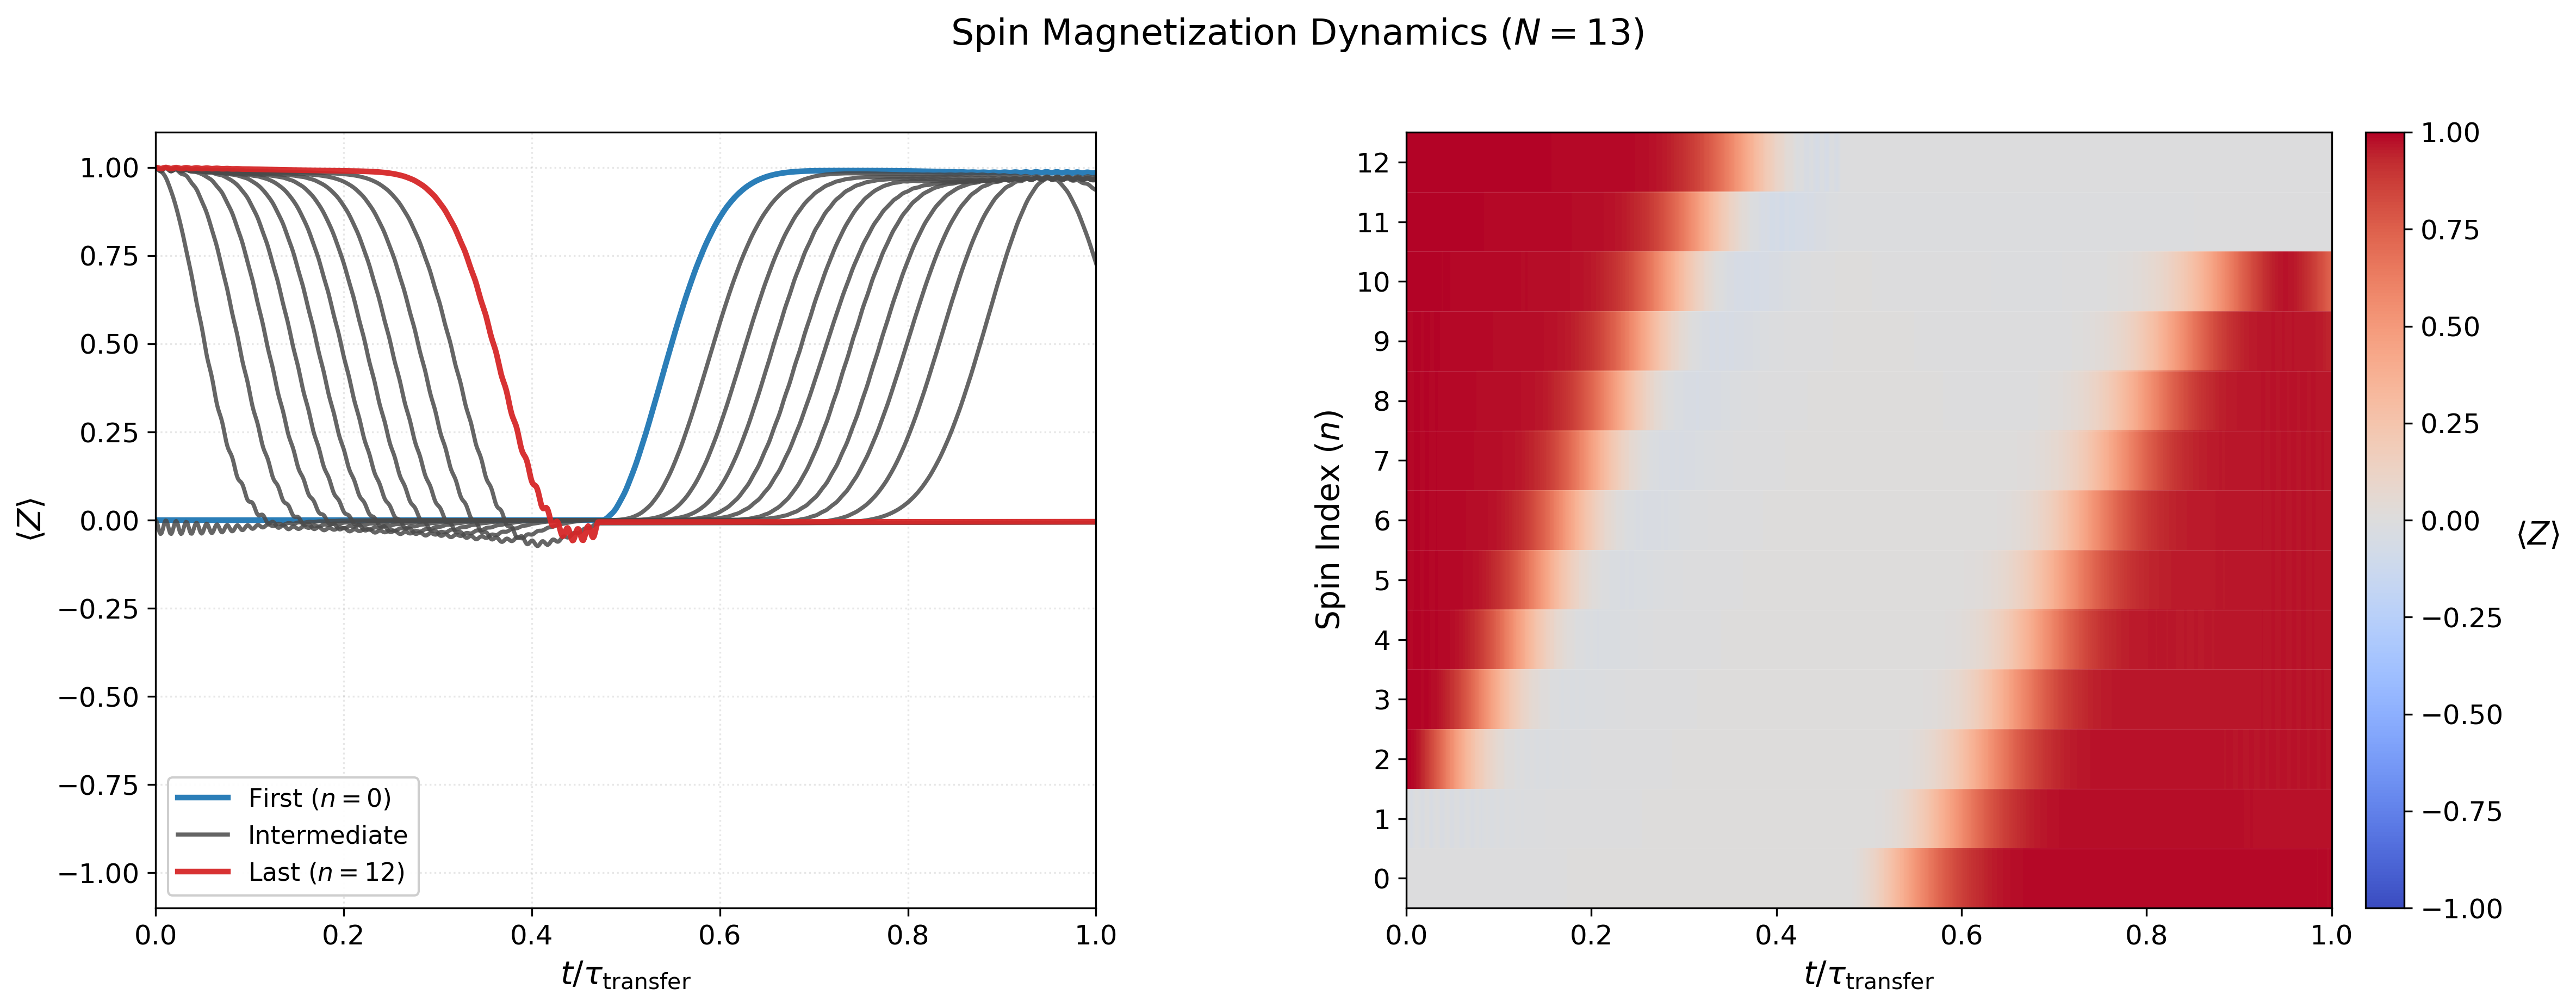

In [97]:
# Create figure with side-by-side subplots
fig = plt.figure(figsize=(16, 6), dpi=300)
gs = GridSpec(1, 2, width_ratios=[1, 1.2])  # Heatmap slightly wider

# Custom colors
first_color = '#1f77b4'  # Blue
last_color = '#d62728'   # Red
middle_color = '#4a4a4a' # Dark gray

# ========== LEFT PANEL: LINE PLOT ==========
ax1 = fig.add_subplot(gs[0])

for i in range(N):
    magn = magnetizations[:,i]
    norm_time = np.linspace(0, 1, len(magn))
    
    lineprops = {
        'color': first_color if i == 0 else (last_color if i == N-1 else middle_color),
        'lw': 2.5 if i in [0, N-1] else 1.8,
        'alpha': 0.95 if i in [0, N-1] else 0.85,
        'label': r'First $(n=0)$' if i == 0 else (r'Last $(n={})$'.format(N-1) if i == N-1 else "")
    }
    if i == 1 and N > 2:
        lineprops['label'] = 'Intermediate'
    
    ax1.plot(norm_time, magn, **lineprops)

# Formatting
ax1.set_xlabel(r'$t/\tau_{\mathrm{transfer}}$', fontsize=14)
ax1.set_ylabel(r'$\langle Z \rangle$', fontsize=14)
ax1.set_ylim(-1.1, 1.1)
ax1.set_xlim(0, 1)
ax1.tick_params(labelsize=12)
ax1.grid(True, linestyle=':', alpha=0.3)

# Simplified legend
handles, labels = ax1.get_legend_handles_labels()
if N > 2:
    # Only show first, last, and one intermediate
    handles = [handles[0], handles[1], handles[-1]] if N > 2 else handles
    labels = [labels[0], 'Intermediate', labels[-1]] if N > 2 else labels
ax1.legend(handles, labels, fontsize=11, framealpha=0.95)

# ========== RIGHT PANEL: HEATMAP ==========
ax2 = fig.add_subplot(gs[1])

# Heatmap with improved display
heatmap = ax2.imshow(
    magnetizations.T,
    aspect='auto',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    extent=(0, 1, 0, N),
    origin='lower',
    interpolation='none'  # Sharp color boundaries
)

# Colorbar with matching style
cbar = fig.colorbar(heatmap, ax=ax2, pad=0.03)
cbar.set_label(r'$\langle Z \rangle$', fontsize=14, rotation=0, labelpad=15)
cbar.ax.tick_params(labelsize=12)

# Clean axis formatting
ax2.set_xlabel(r'$t/\tau_{\mathrm{transfer}}$', fontsize=14)
ax2.set_ylabel('Spin Index ($n$)', fontsize=14)
ax2.set_yticks(np.arange(0.5, N+0.5, 1))
ax2.set_yticklabels(np.arange(N))
ax2.tick_params(labelsize=12)

# Subtle horizontal guides (reduced visibility)
for n in range(1, N):
    ax2.axhline(n, color='white', lw=0.3, alpha=0.15)

# ========== GLOBAL FORMATTING ==========
plt.suptitle(r'Spin Magnetization Dynamics ($N={}$)'.format(N), 
             fontsize=16, y=1.02)

# Final layout adjustment
plt.tight_layout()
plt.subplots_adjust(wspace=0.3)  # Horizontal spacing

# Save
# plt.savefig('figures/good_figures/side_by_side_spin_dynamics.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [245]:
full_fidelity_1 = np.concatenate((f_f, f_b), axis=0)

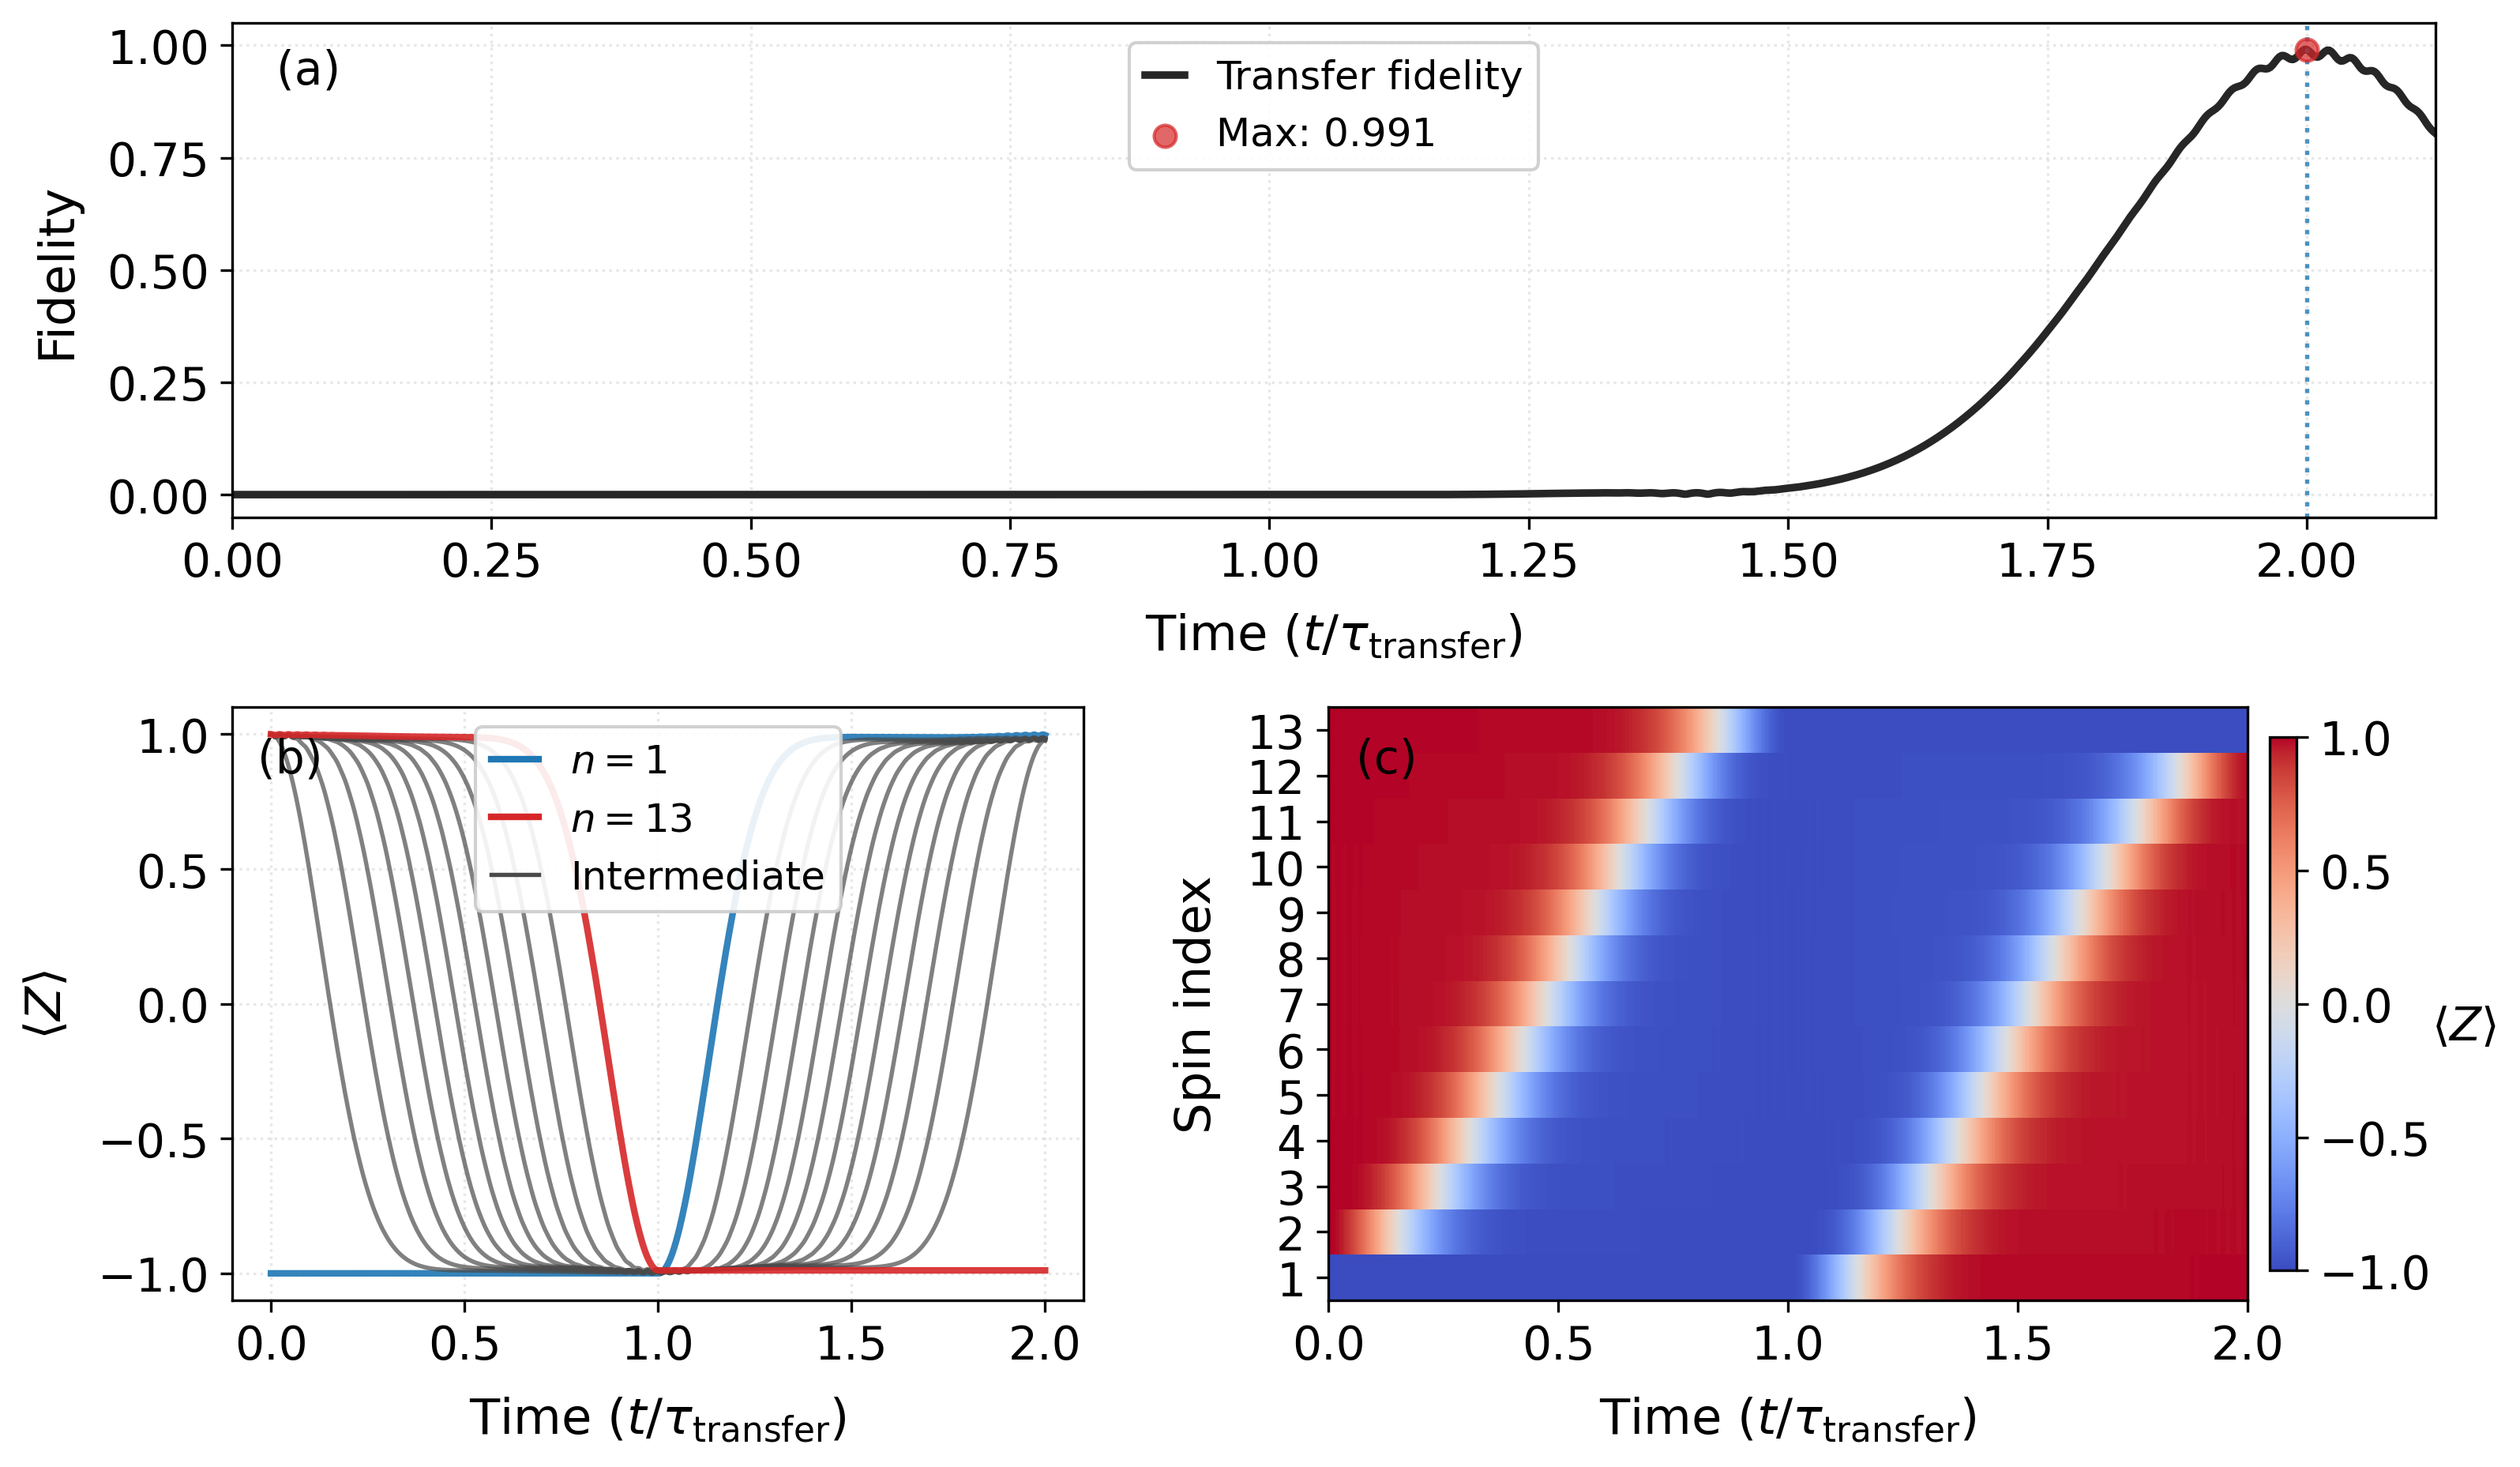

In [22]:

# Find maximum fidelity point
max_fidelity = np.max(full_fidelity_1)
max_time_idx = np.argmax(full_fidelity_1)

# Rescale time axis so maximum occurs at t/τ = 1
original_time = np.linspace(0, 500, len(full_fidelity_1))  # Original 0-7 range
rescale_factor = 0.5*original_time[max_time_idx]  # This will become 1 in new units
rescaled_time = original_time / rescale_factor

# Create unified figure with better proportions
fig = plt.figure(figsize=(12, 7), dpi=300)  # Slightly shorter
gs = GridSpec(2, 2, width_ratios=[1, 1.3], height_ratios=[1, 1.2], 
             hspace=0.35, wspace=0.25)

# Custom colors and style parameters
first_color = '#1f77b4'  # Blue
last_color = '#d62728'   # Red
middle_color = '#4a4a4a' # Dark gray

# ====================== TOP ROW: FIDELITY PLOT ======================
ax1 = fig.add_subplot(gs[0, :])  # Span both columns

# Plot fidelity curve
ax1.plot(rescaled_time, full_fidelity_1, 
         color='#262626', 
         linewidth=2.3,
         label='Transfer fidelity')

# Mark maximum
ax1.scatter([2], [max_fidelity],
            color=last_color,
            s=45,
            alpha=0.7,
            zorder=5,
            label=f'Max: {max_fidelity:.3f}')

# Reference line
ax1.axvline(x=2, color=first_color, linestyle=':', linewidth=1.3, alpha=0.8)

# Formatting
ax1.set_xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=15, labelpad=8)
ax1.set_ylabel('Fidelity', fontsize=15, labelpad=8)
ax1.set_ylim(-0.05, 1.05)
ax1.set_xlim(0, rescaled_time[-1])
ax1.grid(True, linestyle=':', alpha=0.3)
ax1.legend(fontsize=12, framealpha=0.9, loc='upper center', handlelength=1)
ax1.tick_params(labelsize=14)

# Add panel label
ax1.text(0.02, 0.95, '(a)', transform=ax1.transAxes, 
         fontsize=14, va='top')

# ====================== BOTTOM LEFT: SPIN LINES ======================
ax2 = fig.add_subplot(gs[1, 0])

# Plot spin trajectories
for i in range(N):
    magn = magnetizations[:,i]
    norm_time = np.linspace(0, 2, len(magn))
    lineprops = {
        'color': first_color if i == 0 else (last_color if i == N-1 else middle_color),
        'lw': 2 if i in [0, N-1] else 1.3,
        'alpha': 0.9 if i in [0, N-1] else 0.7,
    }
    ax2.plot(norm_time, magnetizations[:,i], **lineprops)

# Only label first and last
ax2.plot([], [], color=first_color, label=r'$n=1$', lw=2)
ax2.plot([], [], color=last_color, label=r'$n={}$'.format(N), lw=2)
if N > 2:
    ax2.plot([], [], color=middle_color, label='Intermediate', lw=1.3)

# Formatting
ax2.set_xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=15, labelpad=8)
ax2.set_ylabel(r'$\langle Z \rangle$', fontsize=15, labelpad=8)
ax2.set_ylim(-1.1, 1.1)
ax2.grid(True, linestyle=':', alpha=0.3)
ax2.tick_params(labelsize=14)

# Compact legend
ax2.legend(fontsize=12, framealpha=0.9, loc='upper center', 
           handlelength=1.2, borderpad=0.4)

# Panel label
ax2.text(0.03, 0.95, '(b)', transform=ax2.transAxes, 
         fontsize=14, va='top')

# ====================== BOTTOM RIGHT: HEATMAP ======================
ax3 = fig.add_subplot(gs[1, 1])

# Heatmap with improved contrast
heatmap = ax3.imshow(
    magnetizations.T,
    aspect='auto',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    extent=(0, 2, 0, N),
    origin='lower',
    interpolation='none'
)

# Compact colorbar
cbar = fig.colorbar(heatmap, ax=ax3, pad=0.02, shrink=0.9)
cbar.set_label(r'$\langle Z \rangle$', fontsize=14, rotation=0, labelpad=10)
cbar.ax.tick_params(labelsize=14)

# Formatting
ax3.set_xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=15, labelpad=8)
ax3.set_ylabel('Spin index', fontsize=15, labelpad=8)
ax3.set_yticks(np.arange(0.5, N+0.5, 1))
ax3.set_yticklabels(np.arange(1, N+1))
ax3.tick_params(labelsize=14)

# Panel label
ax3.text(0.03, 0.95, '(c)', transform=ax3.transAxes, 
         fontsize=14, va='top')

# ====================== GLOBAL FORMATTING ======================
# # Main title (optional - can remove if space is tight)
# fig.suptitle(r'Spin Chain Dynamics ($N={}$)'.format(N), 
#              fontsize=16, y=0.99)

# Final adjustments
plt.savefig('figures/figures_v3/integrated_dynamics_domain_wall.pdf', 
            bbox_inches='tight', dpi=300)
plt.show()

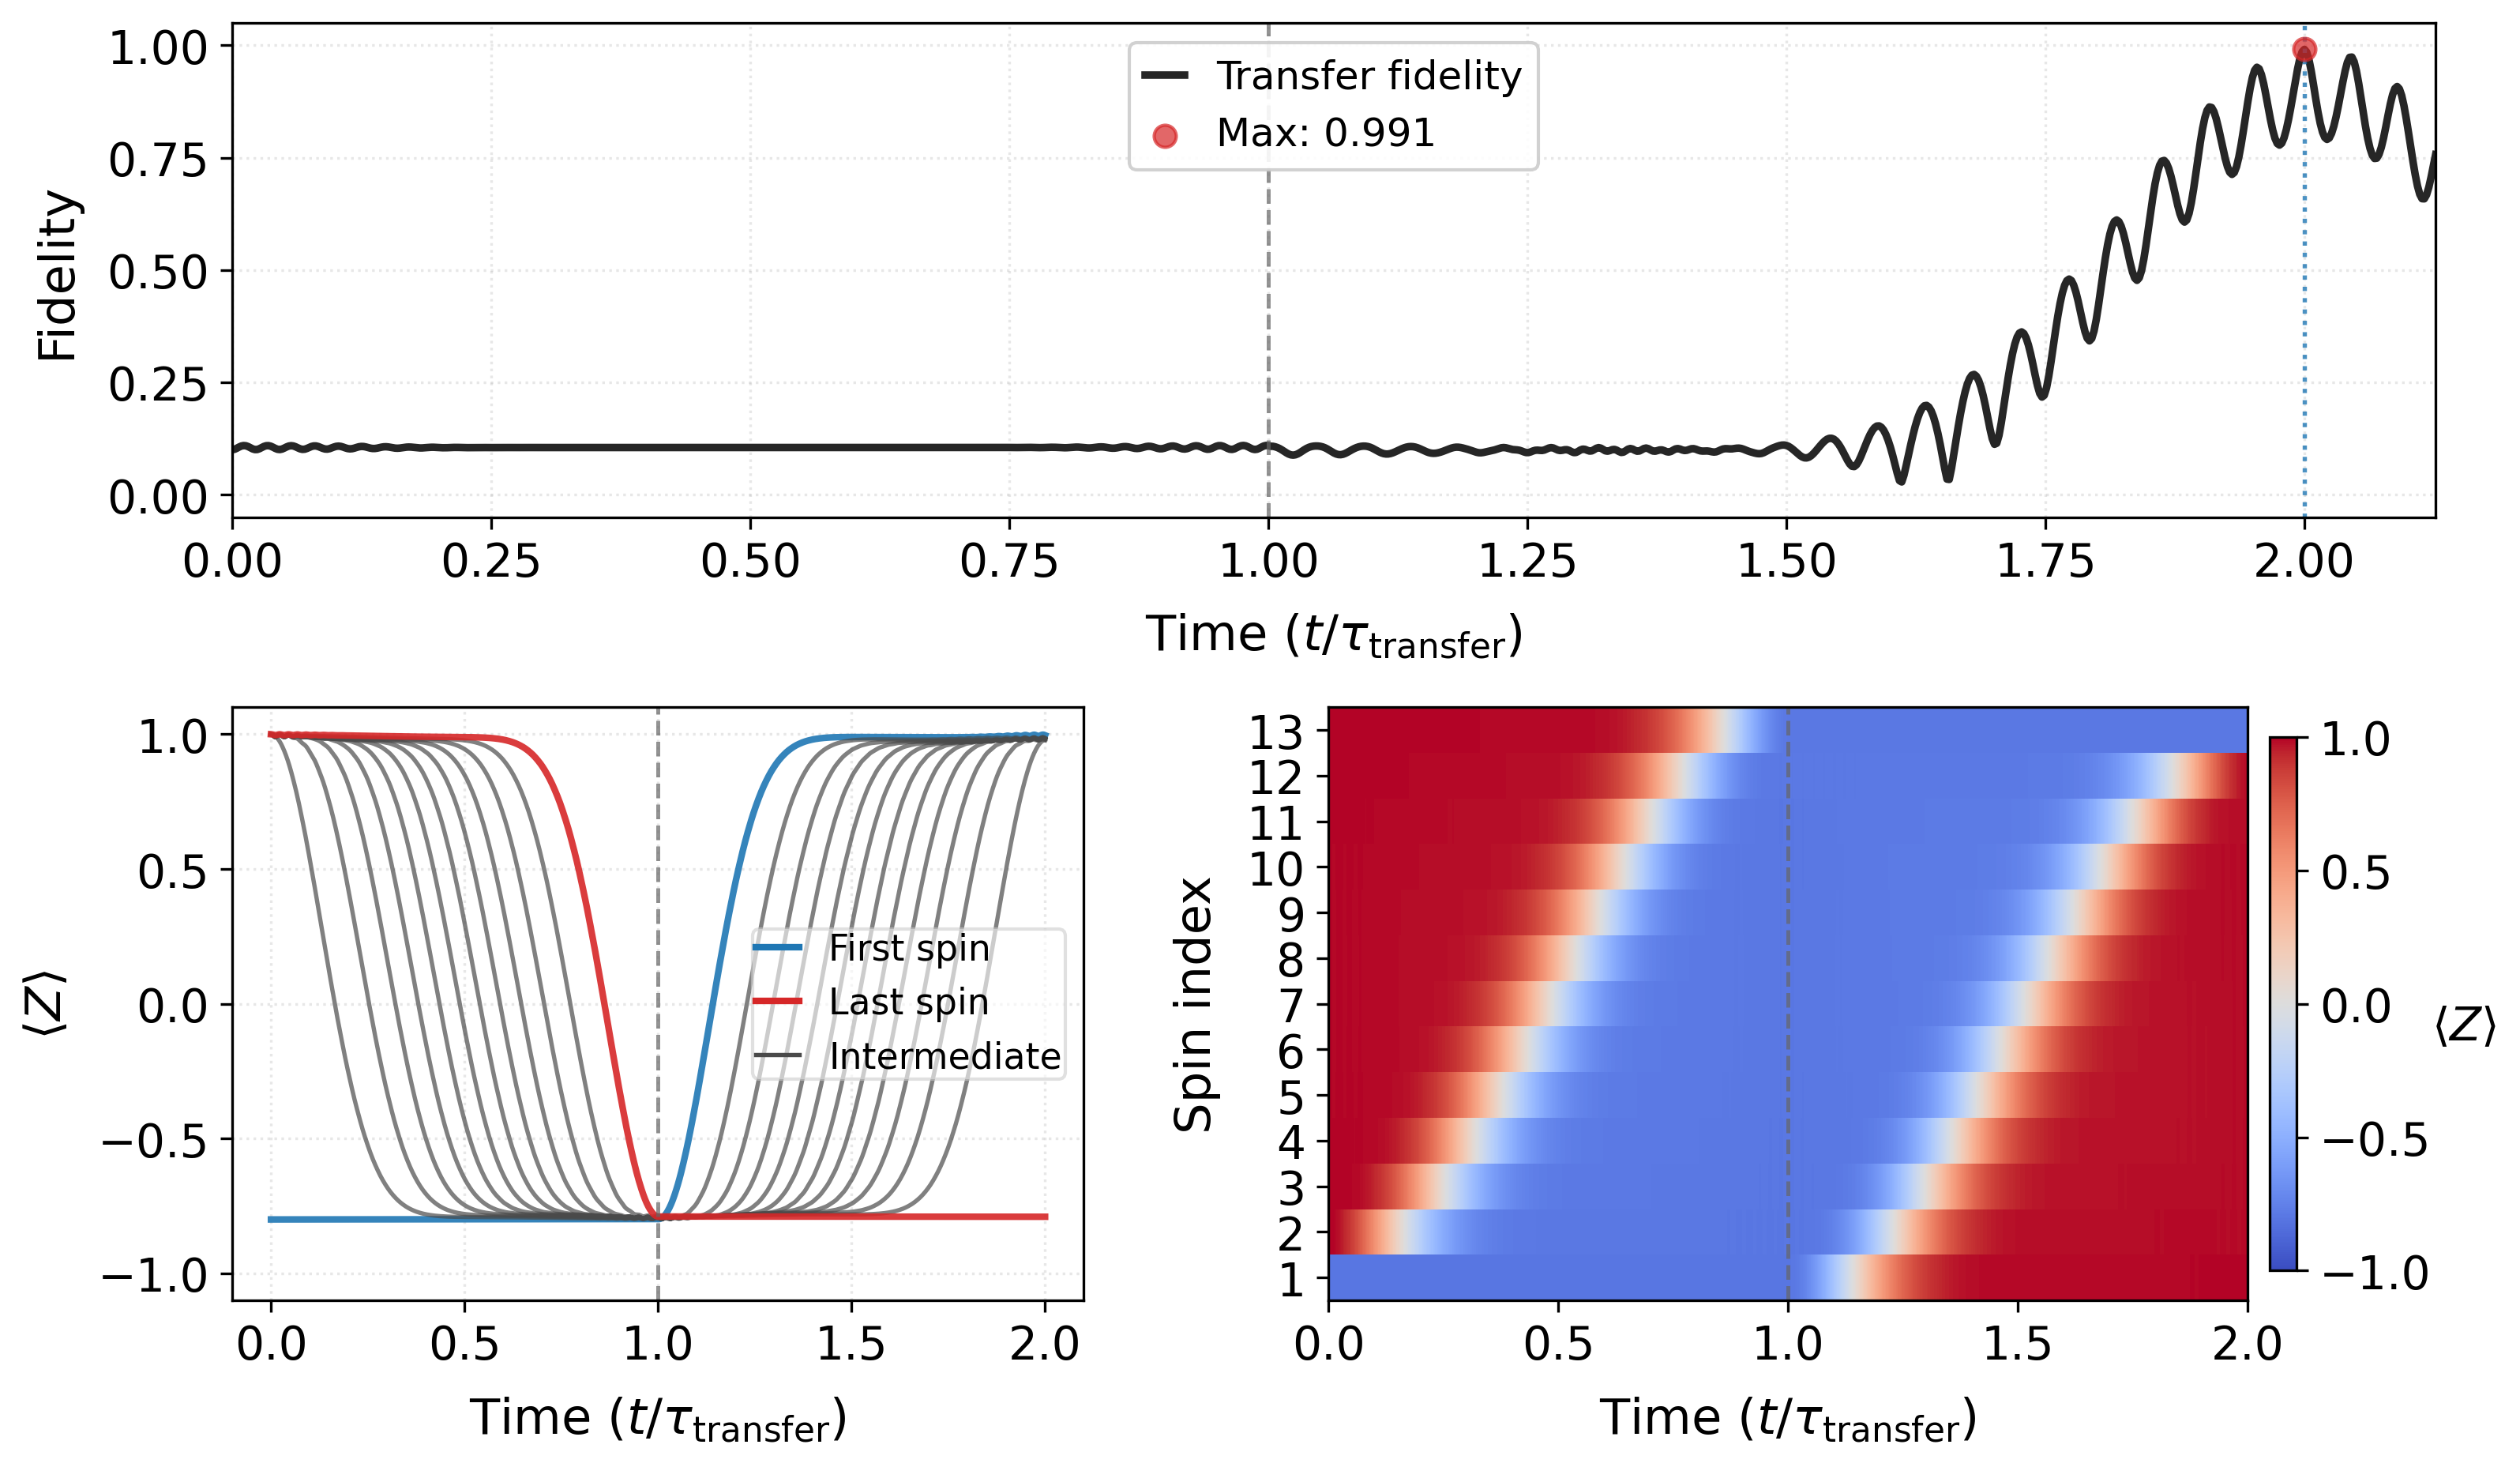

In [ ]:
# Find maximum fidelity point
max_fidelity = np.max(full_fidelity_1)
max_time_idx = np.argmax(full_fidelity_1)

# Rescale time axis so maximum occurs at t/τ = 1
original_time = np.linspace(0, 500, len(full_fidelity_1))  # Original 0-7 range
rescale_factor = 0.5*original_time[max_time_idx]  # This will become 1 in new units
rescaled_time = original_time / rescale_factor

# Create unified figure with better proportions
fig = plt.figure(figsize=(12, 7), dpi=300)  # Slightly shorter
gs = GridSpec(2, 2, width_ratios=[1, 1.3], height_ratios=[1, 1.2], 
             hspace=0.35, wspace=0.25)

# Custom colors and style parameters
first_color = '#1f77b4'  # Blue
last_color = '#d62728'   # Red
middle_color = '#4a4a4a' # Dark gray
switch_line_style = {'linestyle': '--', 'color': '#666666', 'linewidth': 1.2, 'alpha': 0.7}  # Added for switch line

# ====================== TOP ROW: FIDELITY PLOT ======================
ax1 = fig.add_subplot(gs[0, :])  # Span both columns

# Plot fidelity curve
ax1.plot(rescaled_time, full_fidelity_1, 
         color='#262626', 
         linewidth=2.3,
         label='Transfer fidelity')

# Mark maximum
ax1.scatter([2], [max_fidelity],
            color=last_color,
            s=45,
            alpha=0.7,
            zorder=5,
            label=f'Max: {max_fidelity:.3f}')

# Reference line
ax1.axvline(x=2, color=first_color, linestyle=':', linewidth=1.3, alpha=0.8)

# Add Hamiltonian switch line (NEW)
ax1.axvline(x=1, **switch_line_style)

# Formatting
ax1.set_xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=15, labelpad=8)
ax1.set_ylabel('Fidelity', fontsize=15, labelpad=8)
ax1.set_ylim(-0.05, 1.05)
ax1.set_xlim(0, rescaled_time[-1])
ax1.grid(True, linestyle=':', alpha=0.3)
ax1.legend(fontsize=12, framealpha=0.9, loc='upper center', handlelength=1)
ax1.tick_params(labelsize=14)

# Add panel label
# ax1.text(0.02, 0.95, '(a)', transform=ax1.transAxes, 
#          fontsize=14, va='top')

# ====================== BOTTOM LEFT: SPIN LINES ======================
ax2 = fig.add_subplot(gs[1, 0])

# Plot spin trajectories
for i in range(N):
    magn = magnetizations[:,i]
    norm_time = np.linspace(0, 2, len(magn))
    lineprops = {
        'color': first_color if i == 0 else (last_color if i == N-1 else middle_color),
        'lw': 2 if i in [0, N-1] else 1.3,
        'alpha': 0.9 if i in [0, N-1] else 0.7,
    }
    ax2.plot(norm_time, magnetizations[:,i], **lineprops)

# Add Hamiltonian switch line (NEW)
ax2.axvline(x=1, **switch_line_style)

# Only label first and last
ax2.plot([], [], color=first_color, label=r'First spin', lw=2)
ax2.plot([], [], color=last_color, label=r'Last spin'.format(N), lw=2)
if N > 2:
    ax2.plot([], [], color=middle_color, label='Intermediate', lw=1.3)

# Formatting
ax2.set_xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=15, labelpad=8)
ax2.set_ylabel(r'$\langle Z \rangle$', fontsize=15, labelpad=8)
ax2.set_ylim(-1.1, 1.1)
ax2.grid(True, linestyle=':', alpha=0.3)
ax2.tick_params(labelsize=14)

# Compact legend
ax2.legend(fontsize=11, framealpha=0.6, loc='center right', 
           handlelength=1.2, borderpad=0.1)

# Panel label
# ax2.text(0.03, 0.95, '(b)', transform=ax2.transAxes, 
#          fontsize=14, va='top')

# ====================== BOTTOM RIGHT: HEATMAP ======================
ax3 = fig.add_subplot(gs[1, 1])

# Heatmap with improved contrast
heatmap = ax3.imshow(
    magnetizations.T,
    aspect='auto',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    extent=(0, 2, 0, N),
    origin='lower',
    interpolation='none'
)

# Add Hamiltonian switch line (NEW)
ax3.axvline(x=1, **switch_line_style)

# Compact colorbar
cbar = fig.colorbar(heatmap, ax=ax3, pad=0.02, shrink=0.9)
cbar.set_label(r'$\langle Z \rangle$', fontsize=14, rotation=0, labelpad=10)
cbar.ax.tick_params(labelsize=14)

# Formatting
ax3.set_xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=15, labelpad=8)
ax3.set_ylabel('Spin index', fontsize=15, labelpad=8)
ax3.set_yticks(np.arange(0.5, N+0.5, 1))
ax3.set_yticklabels(np.arange(1, N+1))
ax3.tick_params(labelsize=14)

# # Panel label
# ax3.text(0.03, 0.95, '(c)', transform=ax3.transAxes, 
#          fontsize=14, va='top')

# ====================== GLOBAL FORMATTING ======================
plt.savefig('figures/presentation/integrated_dynamics_domain_wall.pdf', 
            bbox_inches='tight', dpi=300)
plt.savefig('figures/presentation/integrated_dynamics_domain_wall.png', 
            bbox_inches='tight', dpi=300)

In [75]:
def extract_peak_evolution(num_steps, fidelity_data, min_peak_height=0.2, smooth_points=200):
    """Extract peaks with fixed frequency from start until first natural peak."""
    t = np.linspace(0, num_steps-1, num_steps)
    
    # First find all natural peaks that meet height requirement
    natural_peaks, _ = find_peaks(fidelity_data, height=min_peak_height)
    natural_peak_times = t[natural_peaks]
    natural_peak_values = fidelity_data[natural_peaks]
    
    if len(natural_peaks) < 2:
        # Not enough peaks to determine frequency - return basic data
        return {
            't': t,
            'y': fidelity_data,
            'peak_times': natural_peak_times,
            'peak_values': natural_peak_values,
            'smooth_t': natural_peak_times,
            'smooth_y': natural_peak_values,
            'max_fidelity': max(natural_peak_values) if len(natural_peak_values) > 0 else np.nan
        }
    
    # Calculate peak frequency in data points
    peak_intervals = np.diff(natural_peaks)
    points_per_peak = int(round(np.mean(peak_intervals)))
    
    # Determine first natural peak position
    first_natural_peak_pos = natural_peaks[0]
    
    # Generate regularly spaced peaks from start until first natural peak
    all_peak_positions = []
    
    # Start from first peak and work backwards
    current_pos = first_natural_peak_pos
    while current_pos >= 0:
        all_peak_positions.append(current_pos)
        current_pos -= points_per_peak
    
    # Now go forward from start to first natural peak
    all_peak_positions = sorted(all_peak_positions)
    all_peak_positions = [p for p in all_peak_positions if p <= first_natural_peak_pos]
    
    # Combine with natural peaks (removing duplicates)
    combined_peaks = np.unique(np.concatenate([
        np.array(all_peak_positions),
        natural_peaks
    ]))
    
    # Get corresponding times and values
    peak_times = t[combined_peaks]
    peak_values = fidelity_data[combined_peaks]
    
    # Create smoothed trend
    if len(peak_times) > 1:
        interp_func = interp1d(peak_times, peak_values, kind='cubic', fill_value='extrapolate')
        smooth_t = np.linspace(min(peak_times), max(peak_times), smooth_points)
        smooth_y = interp_func(smooth_t)
    else:
        smooth_t, smooth_y = peak_times, peak_values
    
    return {
        't': t,
        'y': fidelity_data,
        'peak_times': peak_times,
        'peak_values': peak_values,
        'smooth_t': smooth_t,
        'smooth_y': smooth_y,
        'max_fidelity': max(peak_values) if len(peak_values) > 0 else np.nan
    }

In [77]:
def plot_three_fidelity_curves(num_steps, fidelity_data_list, labels=None, colors=None, min_peak_height=0.0):
    """PhD-quality plot of fidelity trends with peak evolution."""
    
    # Default styling (Nature-style colors)
    if labels is None:
        labels = ['Set 1', 'Set 2', 'Set 3']
    if colors is None:
        colors = ['#4E79A7', '#F28E2B', '#59A14F']  # Muted blue, orange, green
    
    fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
    
    # Process and plot each dataset
    for i, fidelity_data in enumerate(fidelity_data_list):
        data = extract_peak_evolution(len(fidelity_data), fidelity_data, min_peak_height)
        
        # Rescale time axis from 0 to 2
        rescaled_t = data['t'] / (num_steps-1) * 2
        rescaled_peak_times = data['peak_times'] / (num_steps-1) * 2
        rescaled_smooth_t = data['smooth_t'] / (num_steps-1) * 2
        
        # Original data (very faint)
        ax.plot(rescaled_t, data['y'], color=colors[i], alpha=0.3, linewidth=0.8, zorder=1)
        
        # Peaks (no legend entry)
        ax.scatter(rescaled_peak_times, data['peak_values'], 
                  color=colors[i], s=25, alpha=0.7, zorder=2, 
                  edgecolors='k', linewidths=0.3)
        
        # Smoothed trend (with max value in legend)
        ax.plot(rescaled_smooth_t, data['smooth_y'], 
               color=colors[i], linewidth=2.5, 
               label=fr'{labels[i]} ($F_{{\max}} = {data["max_fidelity"]:.3f}$)',
               zorder=3)
    
    # Professional formatting with requested modifications
    ax.set_xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=14, labelpad=10)
    ax.set_ylabel('Fidelity', fontsize=14, labelpad=10)
    ax.tick_params(labelsize=14)
    
    # # Add (a) label in top-left corner
    # ax.text(0.02, 0.98, '(b)', transform=ax.transAxes, 
    #         fontsize=16, va='top', ha='left')
    
    # Legend without peaks
    legend = ax.legend(frameon=False, framealpha=1, 
                      loc='upper left',
                      borderpad=0.8, handlelength=1.5,
                      fontsize=12)
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_linewidth(0.5)
    
    # Grid and spines
    ax.grid(True, linestyle=':', color='lightgray', alpha=0.7)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_color('k')
        ax.spines[spine].set_linewidth(0.7)
    
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(0, 2)  # Rescaled to 0-2
    
    # Save as vector graphic for publications
    plt.savefig('figures/fidelity_peaks_2-qubit.pdf', format='pdf', bbox_inches='tight')
    plt.savefig('figures/fidelity_peaks_2-qubit.png', format='png', bbox_inches='tight')
    plt.show()

In [87]:
def plot_three_fidelity_curves_2(num_steps, fidelity_data_list, labels=None, colors=None, min_peak_height=0.0):
    """PhD-quality plot of fidelity trends with peak evolution."""
    
    # Default styling (Nature-style colors)
    if labels is None:
        labels = ['Set 1', 'Set 2', 'Set 3']
    if colors is None:
        colors = ['#4E79A7', '#F28E2B', '#59A14F']  # Muted blue, orange, green
    
    fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
    
    # First pass to find the time of maximum for the orange line (index 1)
    orange_data = extract_peak_evolution(len(fidelity_data_list[1]), fidelity_data_list[1], min_peak_height)
    max_time_orange = orange_data['smooth_t'][np.argmax(orange_data['smooth_y'])]
    scaling_factor = 2 / (max_time_orange / (num_steps-1))  # This will make max_time_orange correspond to 2
    
    # Process and plot each dataset
    for i, fidelity_data in enumerate(fidelity_data_list):
        data = extract_peak_evolution(len(fidelity_data), fidelity_data, min_peak_height)
        
        # Rescale time axis so orange maximum is at 2
        rescaled_t = data['t'] / (num_steps-1) * scaling_factor
        rescaled_peak_times = data['peak_times'] / (num_steps-1) * scaling_factor
        rescaled_smooth_t = data['smooth_t'] / (num_steps-1) * scaling_factor
        
        # Original data (very faint)
        ax.plot(rescaled_t, data['y'], color=colors[i], alpha=0.3, linewidth=0.8, zorder=1)
        
        # Peaks (no legend entry)
        ax.scatter(rescaled_peak_times, data['peak_values'], 
                  color=colors[i], s=25, alpha=0.7, zorder=2, 
                  edgecolors='k', linewidths=0.3)
        
        # Smoothed trend (with max value in legend)
        ax.plot(rescaled_smooth_t, data['smooth_y'], 
               color=colors[i], linewidth=2.5, 
               label=fr'{labels[i]} ($F_{{\max}} = {data["max_fidelity"]:.3f}$)',
               zorder=3)
    
    # Professional formatting with requested modifications
    ax.set_xlabel(r'Time ($t/\tau_{\mathrm{transfer}}$)', fontsize=14, labelpad=10)
    ax.set_ylabel('Fidelity', fontsize=14, labelpad=10)
    ax.tick_params(labelsize=14)
    
    # Legend without peaks
    legend = ax.legend(frameon=False, framealpha=1, 
                      loc='upper left',
                      borderpad=0.8, handlelength=1.5,
                      fontsize=12)
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_linewidth(0.5)
    
    # Grid and spines
    ax.grid(True, linestyle=':', color='lightgray', alpha=0.7)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_color('k')
        ax.spines[spine].set_linewidth(0.7)
    
    ax.set_ylim(-0.05, 1.05)
    # Set xlim based on the scaling factor (0 to 2*scaling_factor might not be appropriate)
    # Instead, find the maximum time across all datasets after rescaling
    max_x = max([max(data['t'] / (num_steps-1)) * scaling_factor for data in 
                [extract_peak_evolution(len(fd), fd, min_peak_height) for fd in fidelity_data_list]])
    ax.set_xlim(0, max_x)
    
    # Save as vector graphic for publications
    plt.savefig('figures/fidelity_peaks_3-qubit.pdf', format='pdf', bbox_inches='tight')
    plt.savefig('figures/fidelity_peaks_3-qubit.png', format='png', bbox_inches='tight')
    plt.show()

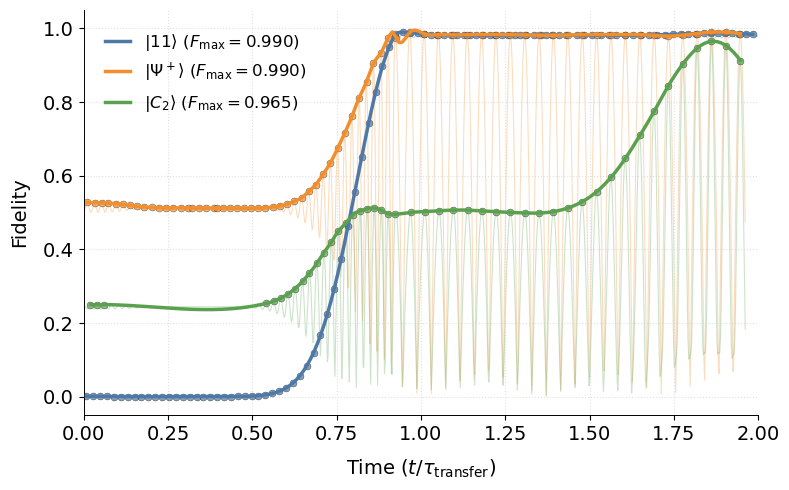

In [86]:
# Example usage
plot_three_fidelity_curves(
    num_steps=len(fidelity_11),
    fidelity_data_list=[fidelity_11_recovered, fidelity_bell_recovered, fidelity_cluster_2_recovered],
    labels=[r'$|11\rangle$', r'$|\Psi^+\rangle$', r'$|C_2\rangle$'],
    min_peak_height=0.25
)

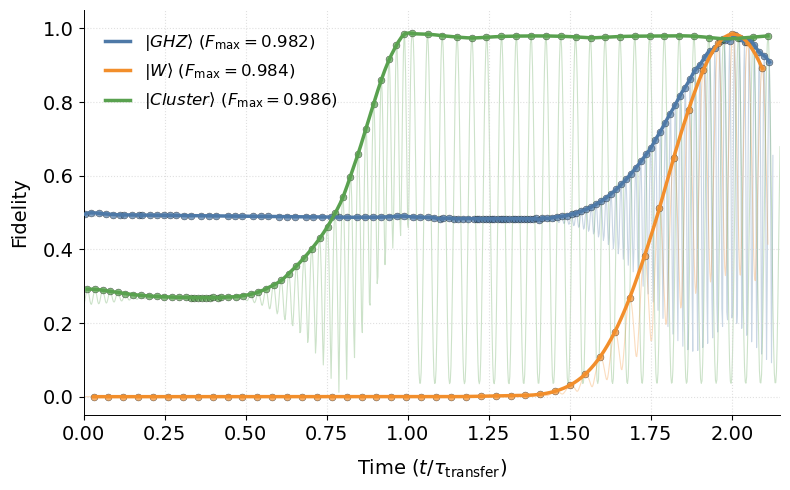

In [88]:
# Example usage
plot_three_fidelity_curves_2(
    num_steps=len(fidelity_cluster_3),
    fidelity_data_list=[fidelity_ghz_recovered, fidelity_w_recovered, fidelity_cluster_3_recovered],
    labels=[r'$|GHZ\rangle$', r'$|W\rangle$', r'$|Cluster\rangle$'],
    min_peak_height=0.25
)

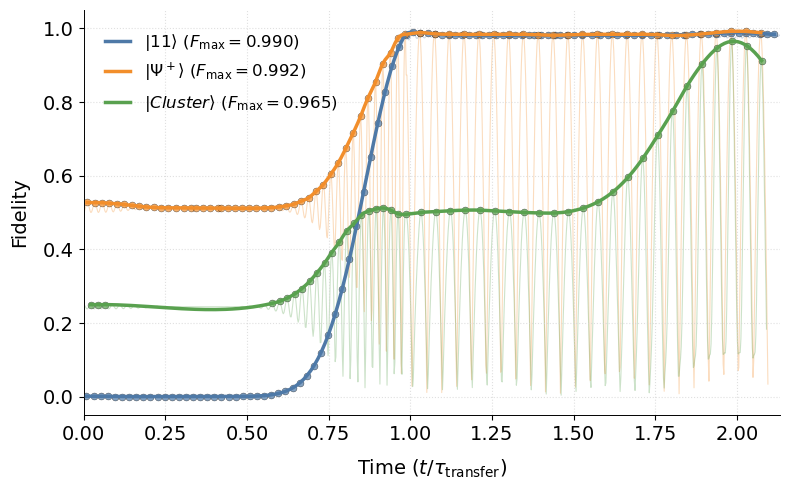

In [102]:
plot_three_fidelity_curves_2(
    num_steps=len(fidelity_cluster_2),
    fidelity_data_list=[fidelity_11, fidelity_bell, fidelity_cluster_2],
    labels=[r'$|11\rangle$', r'$|\Psi^+\rangle$', r'$|Cluster\rangle$'],
    min_peak_height=0.25
)

In [52]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def extract_peak_evolution(fidelity_data, min_peak_height=0.2, smooth_points=200):
    """Extract peaks with fixed frequency from start until first natural peak."""
    num_steps = len(fidelity_data)  # Get length from the data itself
    t = np.linspace(0, num_steps-1, num_steps)
    
    # First find all natural peaks that meet height requirement
    natural_peaks, _ = find_peaks(fidelity_data, height=min_peak_height)
    natural_peak_times = t[natural_peaks]
    natural_peak_values = fidelity_data[natural_peaks]
    
    if len(natural_peaks) < 2:
        # Not enough peaks to determine frequency - return basic data
        return {
            't': t,
            'y': fidelity_data,
            'peak_times': natural_peak_times,
            'peak_values': natural_peak_values,
            'smooth_t': natural_peak_times,
            'smooth_y': natural_peak_values,
            'max_fidelity': max(natural_peak_values) if len(natural_peak_values) > 0 else np.nan
        }
    
    # Calculate peak frequency in data points
    peak_intervals = np.diff(natural_peaks)
    points_per_peak = int(round(np.mean(peak_intervals)))
    
    # Determine first natural peak position
    first_natural_peak_pos = natural_peaks[0]
    
    # Generate regularly spaced peaks from start until first natural peak
    all_peak_positions = []
    
    # Start from first peak and work backwards
    current_pos = first_natural_peak_pos
    while current_pos >= 0:
        all_peak_positions.append(current_pos)
        current_pos -= points_per_peak
    
    # Now go forward from start to first natural peak
    all_peak_positions = sorted(all_peak_positions)
    all_peak_positions = [p for p in all_peak_positions if p <= first_natural_peak_pos]
    
    # Combine with natural peaks (removing duplicates)
    combined_peaks = np.unique(np.concatenate([
        np.array(all_peak_positions),
        natural_peaks
    ]))
    
    # Get corresponding times and values
    peak_times = t[combined_peaks]
    peak_values = fidelity_data[combined_peaks]
    
    # Create smoothed trend
    if len(peak_times) > 1:
        interp_func = interp1d(peak_times, peak_values, kind='cubic', fill_value='extrapolate')
        smooth_t = np.linspace(min(peak_times), max(peak_times), smooth_points)
        smooth_y = interp_func(smooth_t)
    else:
        smooth_t, smooth_y = peak_times, peak_values
    
    return {
        't': t,
        'y': fidelity_data,
        'peak_times': peak_times,
        'peak_values': peak_values,
        'smooth_t': smooth_t,
        'smooth_y': smooth_y,
        'max_fidelity': max(peak_values) if len(peak_values) > 0 else np.nan
    }

def plot_three_fidelity_curves(fidelity_data_list, labels=None, colors=None, min_peak_height=0.0, ax=None):
    """Plot three fidelity curves with specified styling."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    # Default styling (Nature-style colors)
    if labels is None:
        labels = ['Set 1', 'Set 2', 'Set 3']
    if colors is None:
        colors = ['#4E79A7', '#F28E2B', '#59A14F']  # Muted blue, orange, green
    
    # Process and plot each dataset
    for i, fidelity_data in enumerate(fidelity_data_list):
        data = extract_peak_evolution(fidelity_data, min_peak_height)
        num_steps = len(fidelity_data)
        
        # Rescale time axis from 0 to 2
        t = data['t'] / (num_steps-1) * 2
        peak_times = data['peak_times'] / (num_steps-1) * 2
        smooth_t = data['smooth_t'] / (num_steps-1) * 2
        
        # Original data (very faint)
        ax.plot(t, data['y'], color=colors[i], alpha=0.1, linewidth=0.8, zorder=1)
        
        # Peaks (no legend entry)
        if len(peak_times) > 0:
            ax.scatter(peak_times, data['peak_values'], 
                      color=colors[i], s=25, alpha=0.7, zorder=2, 
                      edgecolors='k', linewidths=0.3)
        
        # Smoothed trend (with max value in legend)
        ax.plot(smooth_t, data['smooth_y'], 
               color=colors[i], linewidth=2.5, 
               label=fr'{labels[i]} ($F_{{\max}} = {data["max_fidelity"]:.3f}$)',
               zorder=3)
    
    # Formatting
    ax.set_xlabel('Time', fontsize=15, labelpad=10)
    ax.set_ylabel('Fidelity', fontsize=15, labelpad=10)
    
    # Legend
    legend = ax.legend(frameon=True, framealpha=1, 
                      loc='lower right',
                      borderpad=0.8, handlelength=1.5,
                      fontsize=12)
    legend.get_frame().set_edgecolor('k')
    legend.get_frame().set_linewidth(0.5)
    
    # Grid and spines
    ax.grid(True, linestyle=':', color='lightgray', alpha=0.7)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_color('k')
        ax.spines[spine].set_linewidth(0.7)
    
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(0, 2)
    
    return ax

def plot_two_panels(panel_configs, save_path=None):
    """
    Create two side-by-side panels, each with three fidelity curves.
    
    Parameters:
    - panel_configs: List of two panel configurations, each containing:
        ([data1, data2, data3], [labels], [colors])
    - save_path: Optional path to save the figure
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
    
    # Plot first panel
    data_list1, labels1, colors1 = panel_configs[0]
    plot_three_fidelity_curves(data_list1, labels1, colors1, ax=ax1)
    ax1.text(0.02, 0.98, '(a)', transform=ax1.transAxes, 
            fontsize=14, va='top', ha='left')
    
    # Plot second panel
    data_list2, labels2, colors2 = panel_configs[1]
    plot_three_fidelity_curves(data_list2, labels2, colors2, ax=ax2)
    ax2.text(0.02, 0.98, '(b)', transform=ax2.transAxes, 
            fontsize=14, va='top', ha='left')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    
    plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

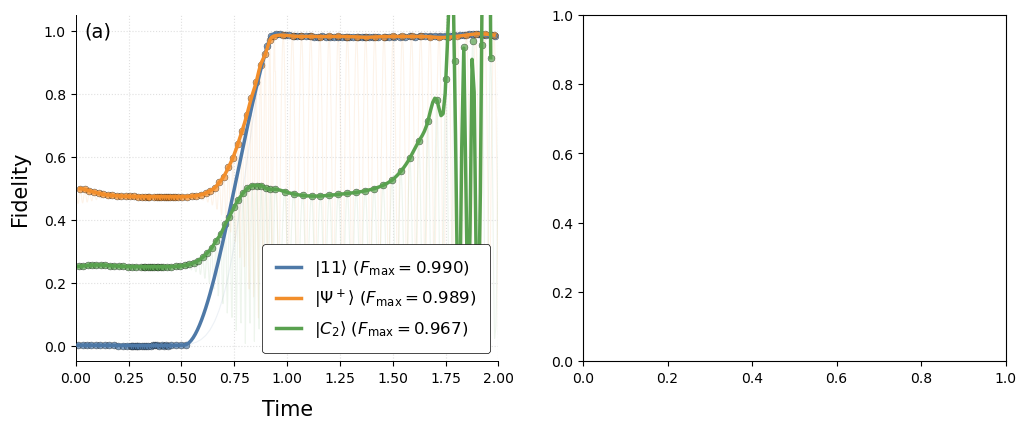

In [207]:
# Create combined plot
num_steps_1=len(fidelity_11)
data_1 = [fidelity_11, fidelity_bell, fidelity_cluster_2]
labels_1 = [r'$|11\rangle$', r'$|\Psi^+\rangle$', r'$|C_2\rangle$']

data_2 = [fidelity_ghz, fidelity_w, fidelity_cluster_3],
labels_2 = [r'$|GHZ\rangle$', r'$|W\rangle$', r'$|Cluster\rangle$']

colors = ['#4E79A7', '#F28E2B', '#59A14F']


plot_two_panels([
    (data_1, labels_1, colors),
    (data_2, labels_2, colors)
], save_path='figures/figures_v3/fidelities.pdf')

In [ ]:
def WRM_algorithm(N, lmd, J, state_dictionary, ti, tf, Nstep):

    #Hamiltonian parameters
    Jn = J_definition(N-1, lmd) 
    tn = tn_definition(Jn)

    #Generate initial and target states
    initial_state = crate_domain_wall_state(state_dictionary)
    target_state = create_domain_wall_target(state_dictionary)

    #Initialization
    register_length = len(initial_state.dims[0])
    sxl, syl, szl = Initialize_Hamiltonian(N)

    # CALIBRATION
    H = Hamiltonian_forward(N, J, tn, sxl, syl, szl) 
    results_c = time_evolution(H, szl, initial_state, ti, tf, Nstep) # evolve
    # calculate fidelity and magnetization
    full_fidelity_c = calculate_full_fidelity(N, results_c, target_state)
    magnetizations_c= calculate_z_expectation_values(N, initial_state, 
                                                     results_c, szl)
    # Determine period of max fidelity
    step_of_min_magnetization = max(int(np.argmin(magnetizations_c[:,-1])),10) 
    period = (tf - ti)*step_of_min_magnetization/Nstep

    # BACK AND FORTH ALGORITHM
    H = Hamiltonian_forward(N, J, tn, sxl, syl, szl) 
    results_f = time_evolution(H, szl, initial_state, ti, period, 
                               int(step_of_min_magnetization))
    full_fidelity_f = calculate_full_fidelity(N, results_f, target_state)
    magnetizations_f = calculate_z_expectation_values(N, initial_state, 
                                                      results_f, szl)

    Jn = J_definition(N-register_length, lmd) #Redefine couplings
    tn = tn_definition(Jn)
    # reset step of chain
    H = Hamiltonian_backward(N, register_length, J, tn, sxl, syl, szl) 
    results_b = time_evolution(H, szl, results_f.states[-1] , ti, period, 
                               int(step_of_min_magnetization))
    full_fidelity_b = calculate_full_fidelity(N, results_b, target_state)
    magnetizations_b = calculate_z_expectation_values(N, initial_state, 
                                                      results_b, szl)

    return full_fidelity_c , full_fidelity_f, full_fidelity_b, \
           step_of_min_magnetization, period, \
           magnetizations_c, magnetizations_f, magnetizations_b